# Character level language model - Dinosaurus land

Welcome to Dinosaurus Island! 65 million years ago, dinosaurs existed, and in this assignment they are back. You are in charge of a special task. Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go berserk, so choose wisely! 

<table>
<td>
<img src="images/dino.jpg" style="width:250;height:300px;">

</td>

</table>

Luckily you have learned some deep learning and you will use it to save the day. Your assistant has collected a list of all the dinosaur names they could find, and compiled them into this [dataset](dinos.txt). (Feel free to take a look by clicking the previous link.) To create new dinosaur names, you will build a character level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. Hopefully this algorithm will keep you and your team safe from the dinosaurs' wrath! 

By completing this assignment you will learn:

- How to store text data for processing using an RNN 
- How to synthesize data, by sampling predictions at each time step and passing it to the next RNN-cell unit
- How to build a character-level text generation recurrent neural network
- Why clipping the gradients is important

We will begin by loading in some functions that we have provided for you in `rnn_utils`. Specifically, you have access to functions such as `rnn_forward` and `rnn_backward` which are equivalent to those you've implemented in the previous assignment. 

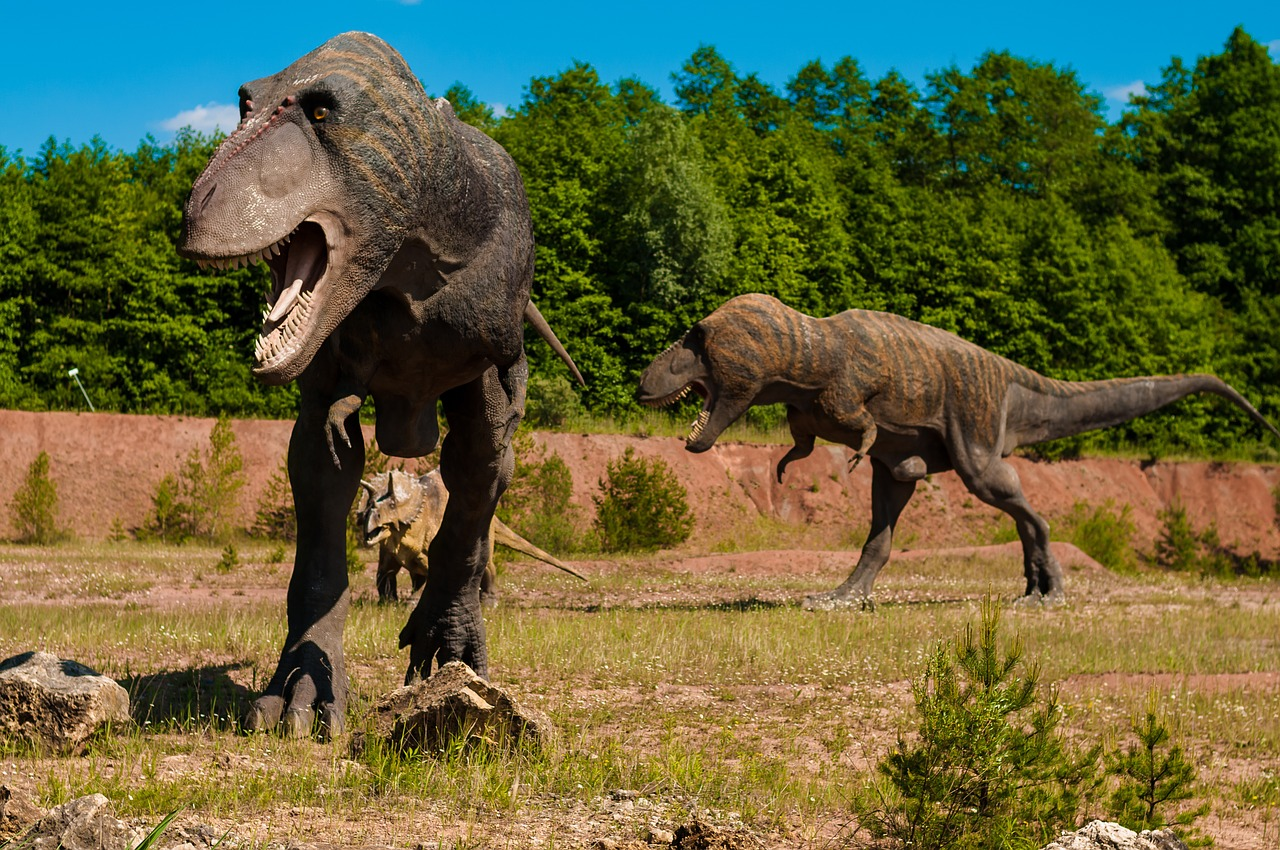

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(filename = "C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/dino.jpg", width=600, height=600)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#from utils import *
import random

In [3]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001

def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    print ('%s' % (txt, ), end='')

def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def initialize_parameters(n_a, n_x, n_y):
    """
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

def rnn_step_forward(parameters, a_prev, x):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b) # hidden state
    p_t = softmax(np.dot(Wya, a_next) + by) # unnormalized log probabilities for next chars # probabilities for next chars 
    
    return a_next, p_t

def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):
    
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next'] # backprop into h
    daraw = (1 - a * a) * da # backprop through tanh nonlinearity
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    return gradients

def update_parameters(parameters, gradients, lr):

    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']
    return parameters

def rnn_forward(X, Y, a0, parameters, vocab_size = 27):
    
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
    
    for t in range(len(X)):
        
        # Set x[t] to be the one-hot vector representation of the t'th character in X.
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector. 
        x[t] = np.zeros((vocab_size,1)) 
        if (X[t] != None):
            x[t][X[t]] = 1
        
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(parameters, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t],0])
        
    cache = (y_hat, a, x)
        
    return loss, cache

def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])
    
    ### START CODE HERE ###
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1])
    ### END CODE HERE ###
    
    return gradients, a

## 1 - Problem Statement

### 1.1 - Dataset and Preprocessing

Run the following cell to read the dataset of dinosaur names, create a list of unique characters (such as a-z), and compute the dataset and vocabulary size. 

In [4]:
data = open('C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.


The characters are a-z (26 characters) plus the "\n" (or newline character), which in this assignment plays a role similar to the `<EOS>` (or "End of sentence") token we had discussed in lecture, only here it indicates the end of the dinosaur name rather than the end of a sentence. In the cell below, we create a python dictionary (i.e., a hash table) to map each character to an index from 0-26. We also create a second python dictionary that maps each index back to the corresponding character character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. Below, `char_to_ix` and `ix_to_char` are the python dictionaries. 

In [5]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }
print(ix_to_char)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 1.2 - Overview of the model

Your model will have the following structure: 

- Initialize parameters 
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update your parameter with the gradient descent update rule.
- Return the learned parameters 
    
<img src="images/rnn.png" style="width:450;height:300px;">
<caption><center> **Figure 1**: Recurrent Neural Network, similar to what you had built in the previous notebook "Building a RNN - Step by Step".  </center></caption>

At each time-step, the RNN tries to predict what is the next character given the previous characters. The dataset $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters in the training set, while $Y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is such that at every time-step $t$, we have $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$. 

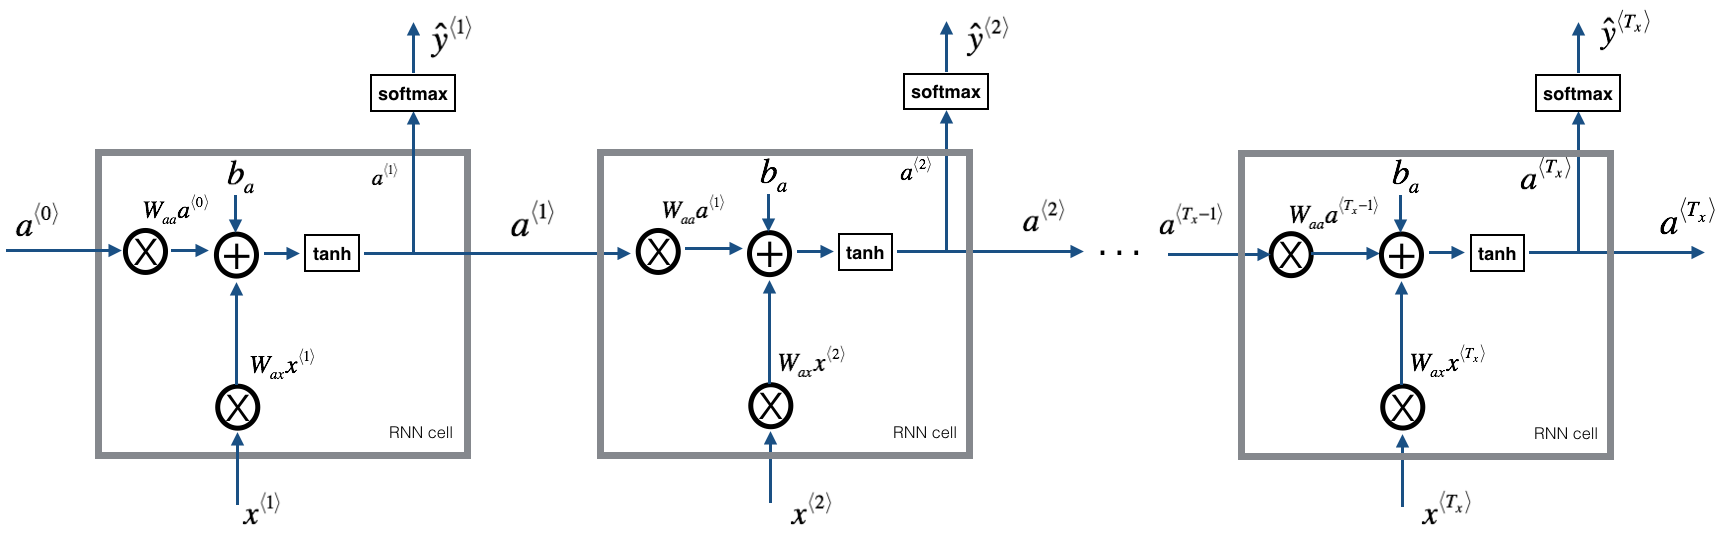

In [7]:
Image(filename = "C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/rnn.png", width=600, height=600)

## 2 - Building blocks of the model

In this part, you will build two important blocks of the overall model:
- Gradient clipping: to avoid exploding gradients
- Sampling: a technique used to generate characters

You will then apply these two functions to build the model.

### 2.1 - Clipping the gradients in the optimization loop

In this section you will implement the `clip` function that you will call inside of your optimization loop. Recall that your overall loop structure usually consists of a forward pass, a cost computation, a backward pass, and a parameter update. Before updating the parameters, you will perform gradient clipping when needed to make sure that your gradients are not "exploding," meaning taking on overly large values. 

In the exercise below, you will implement a function `clip` that takes in a dictionary of gradients and returns a clipped version of gradients if needed. There are different ways to clip gradients; we will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to lie between some range [-N, N]. More generally, you will provide a `maxValue` (say 10). In this example, if any component of the gradient vector is greater than 10, it would be set to 10; and if any component of the gradient vector is less than -10, it would be set to -10. If it is between -10 and 10, it is left alone. 

<img src="images/clip.png" style="width:400;height:150px;">
<caption><center> **Figure 2**: Visualization of gradient descent with and without gradient clipping, in a case where the network is running into slight "exploding gradient" problems. </center></caption>

**Exercise**: Implement the function below to return the clipped gradients of your dictionary `gradients`. Your function takes in a maximum threshold and returns the clipped versions of your gradients. You can check out this [hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) for examples of how to clip in numpy. You will need to use the argument `out = ...`.

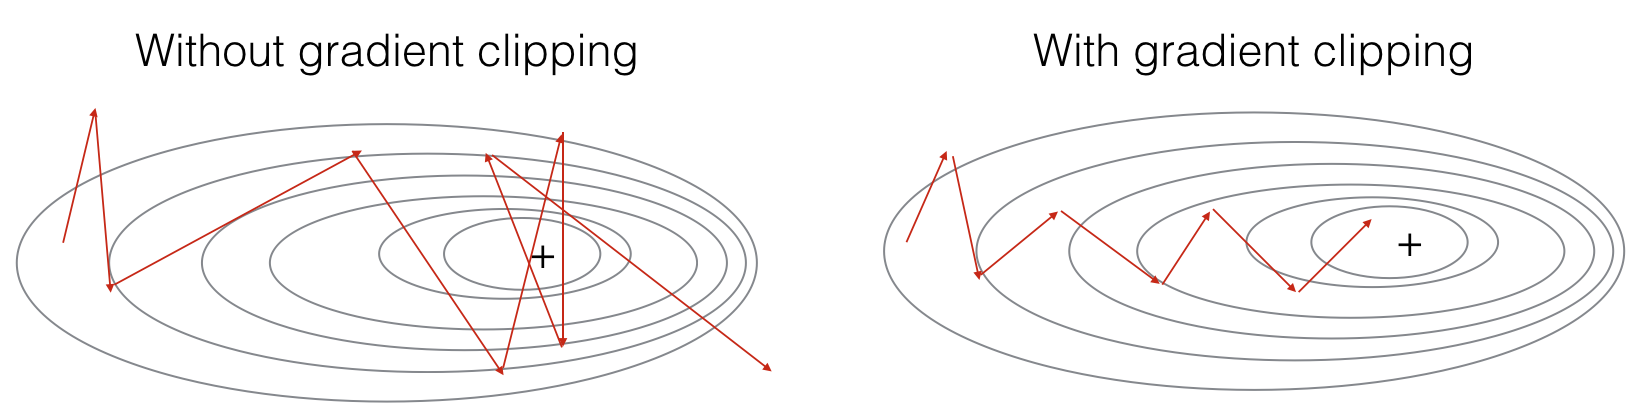

In [9]:
Image(filename = "C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/clip.png", width=600, height=600)

In [10]:
### GRADED FUNCTION: clip

def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    ### START CODE HERE ###
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, gradient)
    ### END CODE HERE ###
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [11]:
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip(gradients, 10)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]


** Expected output:**

<table>
<tr>
    <td> 
    **gradients["dWaa"][1][2] **
    </td>
    <td> 
    10.0
    </td>
</tr>

<tr>
    <td> 
    **gradients["dWax"][3][1]**
    </td>
    <td> 
    -10.0
    </td>
    </td>
</tr>
<tr>
    <td> 
    **gradients["dWya"][1][2]**
    </td>
    <td> 
0.29713815361
    </td>
</tr>
<tr>
    <td> 
    **gradients["db"][4]**
    </td>
    <td> 
[ 10.]
    </td>
</tr>
<tr>
    <td> 
    **gradients["dby"][1]**
    </td>
    <td> 
[ 8.45833407]
    </td>
</tr>

</table>

### 2.2 - Sampling

Now assume that your model is trained. You would like to generate new text (characters). The process of generation is explained in the picture below:

<img src="images/dinos3.png" style="width:500;height:300px;">
<caption><center> **Figure 3**: In this picture, we assume the model is already trained. We pass in $x^{\langle 1\rangle} = \vec{0}$ at the first time step, and have the network then sample one character at a time. </center></caption>

**Exercise**: Implement the `sample` function below to sample characters. You need to carry out 4 steps:

- **Step 1**: Pass the network the first "dummy" input $x^{\langle 1 \rangle} = \vec{0}$ (the vector of zeros). This is the default input before we've generated any characters. We also set $a^{\langle 0 \rangle} = \vec{0}$

- **Step 2**: Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$. Here are the equations:

$$ a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t+1 \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$

$$ z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$

$$ \hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$

Note that $\hat{y}^{\langle t+1 \rangle }$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1). $\hat{y}^{\langle t+1 \rangle}_i$ represents the probability that the character indexed by "i" is the next character.  We have provided a `softmax()` function that you can use.

- **Step 3**: Carry out sampling: Pick the next character's index according to the probability distribution specified by $\hat{y}^{\langle t+1 \rangle }$. This means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$, you will pick the index "i" with 16% probability. To implement it, you can use [`np.random.choice`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.choice.html).

Here is an example of how to use `np.random.choice()`:
```python
np.random.seed(0)
p = np.array([0.1, 0.0, 0.7, 0.2])
index = np.random.choice([0, 1, 2, 3], p = p.ravel())
```
This means that you will pick the `index` according to the distribution: 
$P(index = 0) = 0.1, P(index = 1) = 0.0, P(index = 2) = 0.7, P(index = 3) = 0.2$.

- **Step 4**: The last step to implement in `sample()` is to overwrite the variable `x`, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$. You will represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character you've chosen as your prediction. You will then forward propagate $x^{\langle t + 1 \rangle }$ in Step 1 and keep repeating the process until you get a "\n" character, indicating you've reached the end of the dinosaur name. 

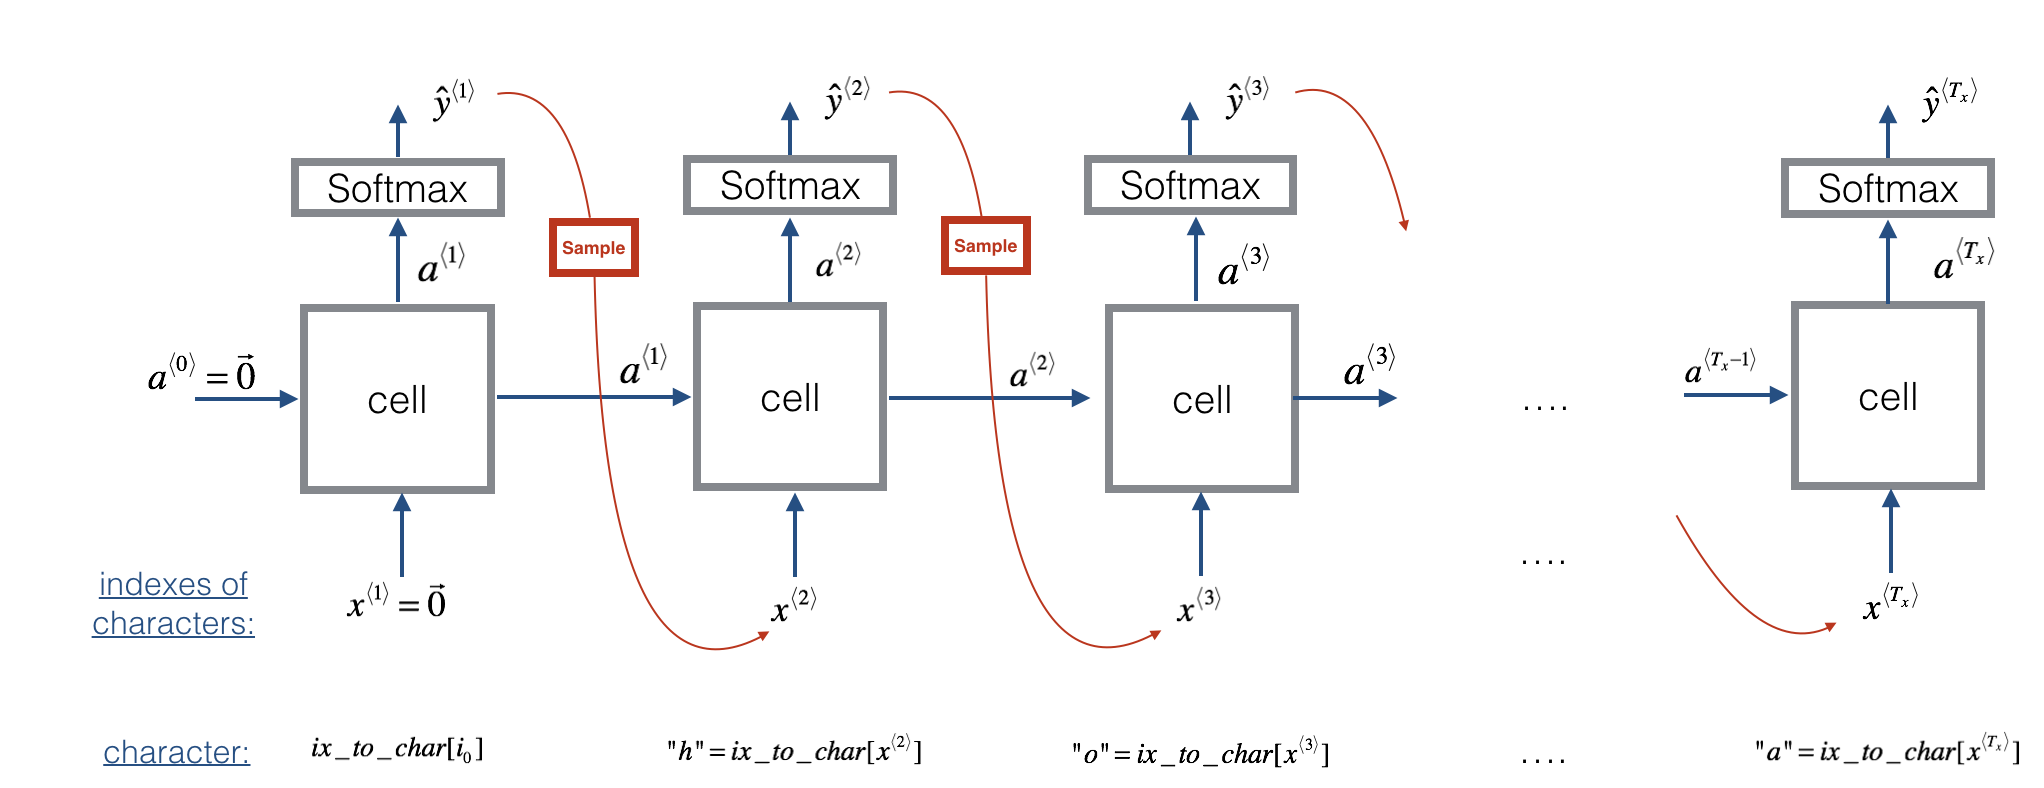

In [12]:
Image(filename = "C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/dinos3.png", width=600, height=600)

In [13]:
# GRADED FUNCTION: sample

def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- python dictionary mapping each character to an index.
    seed -- used for grading purposes. Do not worry about it.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    ### START CODE HERE ###
    # Step 1: Create the one-hot vector x for the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros((vocab_size,1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros((n_a,1))
    
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # Idx is a flag to detect a newline character, we initialize it to -1
    idx = -1 
    
    # Loop over time-steps t. At each time-step, sample a character from a probability distribution and append 
    # its index to "indices". We'll stop if we reach 50 characters (which should be very unlikely with a well 
    # trained model), which helps debugging and prevents entering an infinite loop. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax,x)+np.dot(Waa,a_prev)+b)
        z = np.dot(Wya,a)+by
        y = softmax(z)
        
        # for grading purposes
        np.random.seed(counter+seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        idx = np.random.choice(vocab_size,p=y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input character as the one corresponding to the sampled index.
        x = np.zeros((vocab_size,1))
        x[idx] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed += 1
        counter +=1
        
    ### END CODE HERE ###

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

In [14]:
np.random.seed(2)
_, n_a = 20, 100
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


indices = sample(parameters, char_to_ix, 0)
print("Sampling:")
print("list of sampled indices:", indices)
print("list of sampled characters:", [ix_to_char[i] for i in indices])

Sampling:
list of sampled indices: [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 24, 12, 3, 1, 0]
list of sampled characters: ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'x', 'l', 'c', 'a', '\n']


** Expected output:**
<table>
<tr>
    <td> 
    **list of sampled indices:**
    </td>
    <td> 
    [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, <br>
    7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 5, 6, 12, 25, 0, 0]
    </td>
    </tr><tr>
    <td> 
    **list of sampled characters:**
    </td>
    <td> 
    ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', <br>
    'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', <br>
    'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'e', 'f', 'l', 'y', '\n', '\n']
    </td>
    
        
    
</tr>
</table>

## 3 - Building the language model 

It is time to build the character-level language model for text generation. 


### 3.1 - Gradient descent 

In this section you will implement a function performing one step of stochastic gradient descent (with clipped gradients). You will go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent. As a reminder, here are the steps of a common optimization loop for an RNN:

- Forward propagate through the RNN to compute the loss
- Backward propagate through time to compute the gradients of the loss with respect to the parameters
- Clip the gradients if necessary 
- Update your parameters using gradient descent 

**Exercise**: Implement this optimization process (one step of stochastic gradient descent). 

We provide you with the following functions: 

```python
def rnn_forward(X, Y, a_prev, parameters):
    """ Performs the forward propagation through the RNN and computes the cross-entropy loss.
    It returns the loss' value as well as a "cache" storing values to be used in the backpropagation."""
    ....
    return loss, cache
    
def rnn_backward(X, Y, parameters, cache):
    """ Performs the backward propagation through time to compute the gradients of the loss with respect
    to the parameters. It returns also all the hidden states."""
    ...
    return gradients, a

def update_parameters(parameters, gradients, learning_rate):
    """ Updates parameters using the Gradient Descent Update Rule."""
    ...
    return parameters
```

In [15]:
# GRADED FUNCTION: optimize

def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    ### START CODE HERE ###
    
    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients, 5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    ### END CODE HERE ###
    
    return loss, gradients, a[len(X)-1]

In [16]:
np.random.seed(1)
vocab_size, n_a = 27, 100
a_prev = np.random.randn(n_a, 1)
Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
X = [12,3,5,11,22,3]
Y = [4,14,11,22,25, 26]

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
print("Loss =", loss)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])
print("a_last[4] =", a_last[4])

Loss = 126.50397572165346
gradients["dWaa"][1][2] = 0.1947093153472656
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032004627
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


** Expected output:**

<table>


<tr>
    <td> 
    **Loss **
    </td>
    <td> 
    126.503975722
    </td>
</tr>
<tr>
    <td> 
    **gradients["dWaa"][1][2]**
    </td>
    <td> 
    0.194709315347
    </td>
<tr>
    <td> 
    **np.argmax(gradients["dWax"])**
    </td>
    <td> 93
    </td>
</tr>
<tr>
    <td> 
    **gradients["dWya"][1][2]**
    </td>
    <td> -0.007773876032
    </td>
</tr>
<tr>
    <td> 
    **gradients["db"][4]**
    </td>
    <td> [-0.06809825]
    </td>
</tr>
<tr>
    <td> 
    **gradients["dby"][1]**
    </td>
    <td>[ 0.01538192]
    </td>
</tr>
<tr>
    <td> 
    **a_last[4]**
    </td>
    <td> [-1.]
    </td>
</tr>

</table>

### 3.2 - Training the model 

Given the dataset of dinosaur names, we use each line of the dataset (one name) as one training example. Every 100 steps of stochastic gradient descent, you will sample 10 randomly chosen names to see how the algorithm is doing. Remember to shuffle the dataset, so that stochastic gradient descent visits the examples in random order. 

**Exercise**: Follow the instructions and implement `model()`. When `examples[index]` contains one dinosaur name (string), to create an example (X, Y), you can use this:
```python
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
```
Note that we use: `index= j % len(examples)`, where `j = 1....num_iterations`, to make sure that `examples[index]` is always a valid statement (`index` is smaller than `len(examples)`).
The first entry of `X` being `None` will be interpreted by `rnn_forward()` as setting $x^{\langle 0 \rangle} = \vec{0}$. Further, this ensures that `Y` is equal to `X` but shifted one step to the left, and with an additional "\n" appended to signify the end of the dinosaur name. 

In [17]:
# GRADED FUNCTION: model

def model(data, ix_to_char, char_to_ix, num_iterations = 35000, n_a = 50, dino_names = 7, vocab_size = 27):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text, size of the vocabulary
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss, don't worry about it)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build list of all dinosaur names (training examples).
    with open("dinos.txt") as f:
        examples = f.readlines()
    examples = [x.lower().strip() for x in examples]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # Optimization loop
    for j in range(num_iterations):
        
        ### START CODE HERE ###
        
        # Use the hint above to define one training example (X,Y) (≈ 2 lines)
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]]
        Y = X[1:] + [char_to_ix["\n"]]
        
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X,Y, a_prev, parameters, learning_rate=0.01)
        
        ### END CODE HERE ###
        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                
                seed += 1  # To get the same result for grading purposed, increment the seed by one. 
      
            print('\n')
        
    return parameters

Run the following cell, you should observe your model outputting random-looking characters at the first iteration. After a few thousand iterations, your model should learn to generate reasonable-looking names. 

In [18]:
parameters = model(data, ix_to_char, char_to_ix)

Iteration: 0, Loss: 23.087336

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


Iteration: 2000, Loss: 27.884160

Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


Iteration: 4000, Loss: 25.901815

Mivrosaurus
Inee
Ivtroplisaurus
Mbaaisaurus
Wusichisaurus
Cabaselachus
Toraperlethosdarenitochusthiamamumamaon


Iteration: 6000, Loss: 24.608779

Onwusceomosaurus
Lieeaerosaurus
Lxussaurus
Oma
Xusteonosaurus
Eeahosaurus
Toreonosaurus


Iteration: 8000, Loss: 24.070350

Onxusichepriuon
Kilabersaurus
Lutrodon
Omaaerosaurus
Xutrcheps
Edaksoje
Trodiktonus


Iteration: 10000, Loss: 23.844446

Onyusaurus
Klecalosaurus
Lustodon
Ola
Xusodonia
Eeaeosaurus
Troceosaurus


Iteration: 12000, Loss: 23.291971

Onyxosaurus
Kica
Lustrepiosaurus
Olaagrraiansaurus
Yuspangosaurus
Eealosaurus
Trognesaurus


Iteration: 14000, Loss: 23.382338

Meutromodromurus
Inda
Iutroinatorsaurus
Maca
Yusteratop

## Conclusion

You can see that your algorithm has started to generate plausible dinosaur names towards the end of the training. At first, it was generating random characters, but towards the end you could see dinosaur names with cool endings. Feel free to run the algorithm even longer and play with hyperparameters to see if you can get even better results. Our implemetation generated some really cool names like `maconucon`, `marloralus` and `macingsersaurus`. Your model hopefully also learned that dinosaur names tend to end in `saurus`, `don`, `aura`, `tor`, etc.

If your model generates some non-cool names, don't blame the model entirely--not all actual dinosaur names sound cool. (For example, `dromaeosauroides` is an actual dinosaur name and is in the training set.) But this model should give you a set of candidates from which you can pick the coolest! 

This assignment had used a relatively small dataset, so that you could train an RNN quickly on a CPU. Training a model of the english language requires a much bigger dataset, and usually needs much more computation, and could run for many hours on GPUs. We ran our dinosaur name for quite some time, and so far our favoriate name is the great, undefeatable, and fierce: Mangosaurus!

<img src="images/mangosaurus.jpeg" style="width:250;height:300px;">

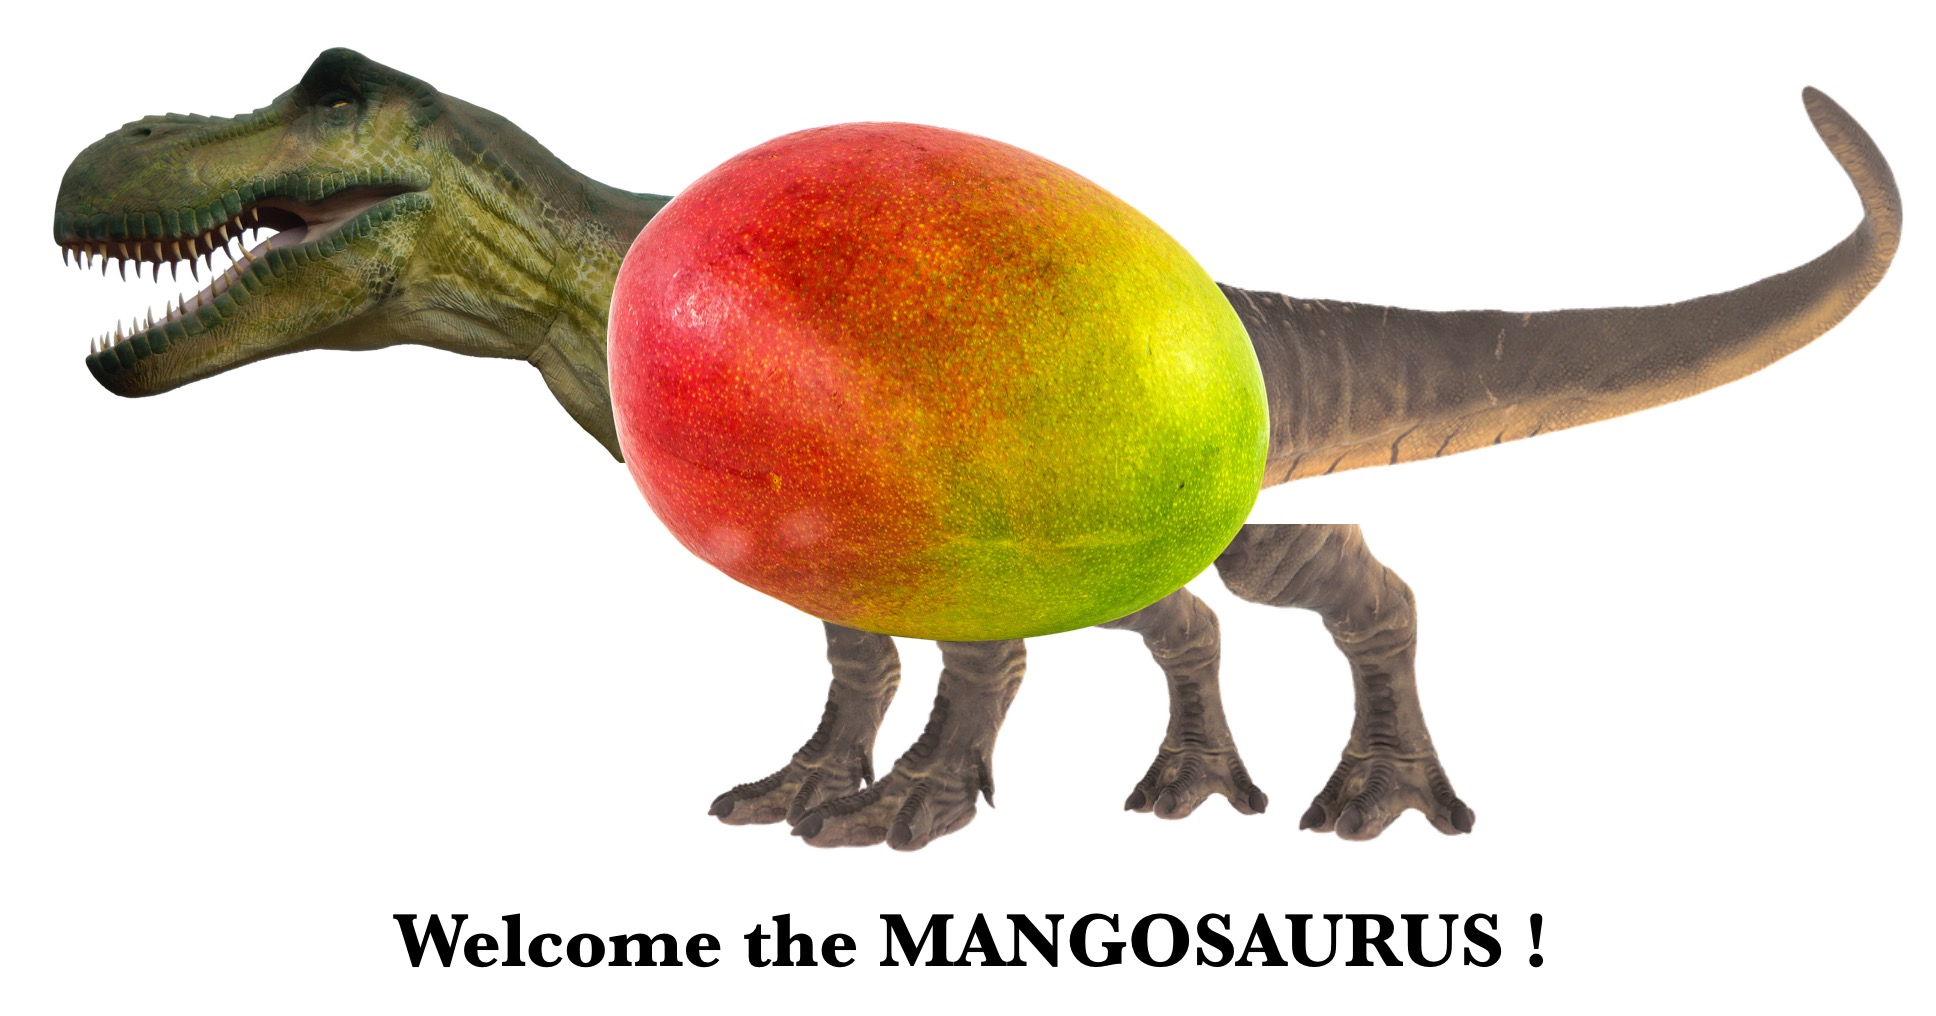

In [19]:
Image(filename = "C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/mangosaurus.jpeg", width=600, height=600)

## 4 - Writing like Shakespeare

The rest of this notebook is optional and is not graded, but we hope you'll do it anyway since it's quite fun and informative. 

A similar (but more complicated) task is to generate Shakespeare poems. Instead of learning from a dataset of Dinosaur names you can use a collection of Shakespearian poems. Using LSTM cells, you can learn longer term dependencies that span many characters in the text--e.g., where a character appearing somewhere a sequence can influence what should be a different character much much later in ths sequence. These long term dependencies were less important with dinosaur names, since the names were quite short. 


<img src="images/shakespeare.jpg" style="width:500;height:400px;">
<caption><center> Let's become poets! </center></caption>

We have implemented a Shakespeare poem generator with Keras. Run the following cell to load the required packages and models. This may take a few minutes. 

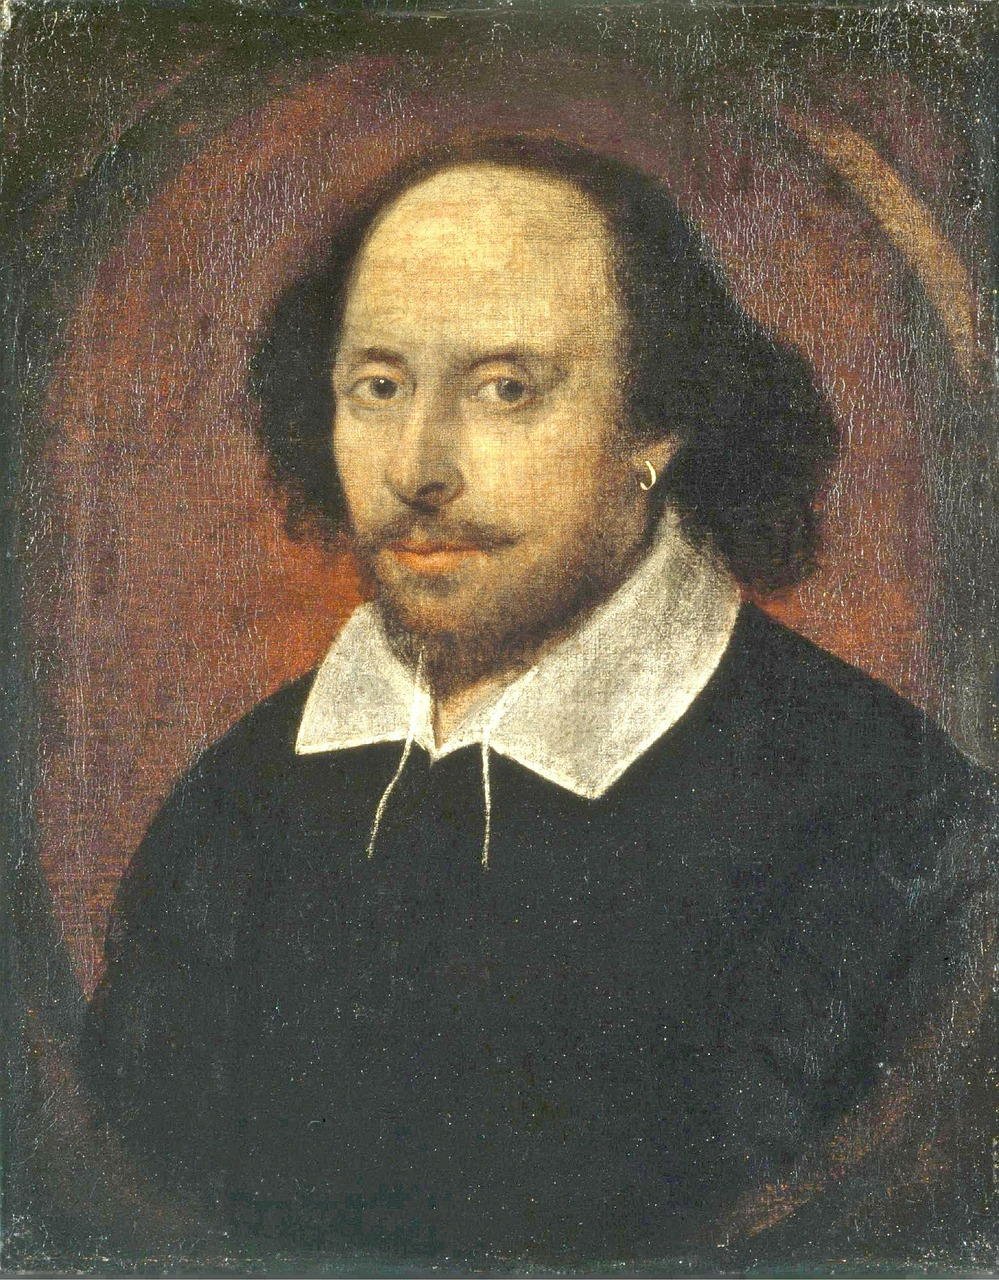

In [20]:
Image(filename = "C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/shakespeare.jpg", width=600, height=600)

In [21]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
#from shakespeare_utils import *
import sys
import io

Using TensorFlow backend.


In [24]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import sys
import io

def build_data(text, Tx = 40, stride = 3):
    """
    Create a training set by scanning a window of size Tx over the text corpus, with stride 3.
    
    Arguments:
    text -- string, corpus of Shakespearian poem
    Tx -- sequence length, number of time-steps (or characters) in one training example
    stride -- how much the window shifts itself while scanning
    
    Returns:
    X -- list of training examples
    Y -- list of training labels
    """
    
    X = []
    Y = []

    ### START CODE HERE ### (≈ 3 lines)
    for i in range(0, len(text) - Tx, stride):
        X.append(text[i: i + Tx])
        Y.append(text[i + Tx])
    ### END CODE HERE ###
    
    print('number of training examples:', len(X))
    
    return X, Y


def vectorization(X, Y, n_x, char_indices, Tx = 40):
    """
    Convert X and Y (lists) into arrays to be given to a recurrent neural network.
    
    Arguments:
    X -- 
    Y -- 
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, len(chars))
    """
    
    m = len(X)
    x = np.zeros((m, Tx, n_x), dtype=np.bool)
    y = np.zeros((m, n_x), dtype=np.bool)
    for i, sentence in enumerate(X):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[Y[i]]] = 1
        
    return x, y 


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p = probas.ravel())
    return out
    #return np.argmax(probas)
    
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    None
    #start_index = random.randint(0, len(text) - Tx - 1)
    
    #generated = ''
    #sentence = text[start_index: start_index + Tx]
    #sentence = '0'*Tx
    #usr_input = input("Write the beginning of your poem, the Shakespearian machine will complete it.")
    # zero pad the sentence to Tx characters.
    #sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    #generated += sentence
#
    #sys.stdout.write(usr_input)

    #for i in range(400):
"""
        #x_pred = np.zeros((1, Tx, len(chars)))
        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 1.0)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
        sys.stdout.write(next_char)
        sys.stdout.flush()
        
        if next_char == '\n':
            continue
        
    # Stop at the end of a line (4 lines)
    print()
 """   
print("Loading text data...")
text = io.open('C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/shakespeare.txt', encoding='utf-8').read().lower()
#print('corpus length:', len(text))

Tx = 40
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
#print('number of unique characters in the corpus:', len(chars))

print("Creating training set...")
X, Y = build_data(text, Tx, stride = 3)
print("Vectorizing training set...")
x, y = vectorization(X, Y, n_x = len(chars), char_indices = char_indices) 
print("Loading model...")
model = load_model('C:/Users/Maikol Cerda/Dropbox/2.-DATA SCIENCE COURSES/0.- COURSERA/3.- DEEP LEARNING (deeplearning.ai)/22.- Sequence Models (deeplearning.ai)/codes/model_shakespeare_kiank_350_epoch.h5')


def generate_output():
    generated = ''
    #sentence = text[start_index: start_index + Tx]
    #sentence = '0'*Tx
    usr_input = input("Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: ")
    # zero pad the sentence to Tx characters.
    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 1.0)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

Loading text data...
Creating training set...
number of training examples: 31412
Vectorizing training set...
Loading model...


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


To save you some time, we have already trained a model for ~1000 epochs on a collection of Shakespearian poems called [*"The Sonnets"*](shakespeare.txt). 

Let's train the model for one more epoch. When it finishes training for an epoch---this will also take a few minutes---you can run `generate_output`, which will prompt asking you for an input (`<`40 characters). The poem will start with your sentence, and our RNN-Shakespeare will complete the rest of the poem for you! For example, try "Forsooth this maketh no sense " (don't enter the quotation marks). Depending on whether you include the space at the end, your results might also differ--try it both ways, and try other inputs as well. 


In [25]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback])

Epoch 1/1
31412/31412 [==============================] - 45s 1ms/step - loss: 2.7159


In [26]:
# Run this cell to try with different inputs without having to re-train the model 
generate_output()

Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: hello how are you


Here is your poem: 

hello how are you.
pusts cime outhangth and on thing nold? see fors ol is thy sun to dray,
then greture brisw eot tosd, and yes my sade:
it with heart a dondow anfaweinc dears,
the behond's, klongst of wa,ding with be,
low is wueth thus you no full jose of day,
and worms leve rihe thist so camlong by freel,
dreen comlote of her betoon ouly herainy,
now love some cinde and beausy miding fided.
they bebut dithaths w

The RNN-Shakespeare model is very similar to the one you have built for dinosaur names. The only major differences are:
- LSTMs instead of the basic RNN to capture longer-range dependencies
- The model is a deeper, stacked LSTM model (2 layer)
- Using Keras instead of python to simplify the code 

If you want to learn more, you can also check out the Keras Team's text generation implementation on GitHub: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py.

Congratulations on finishing this notebook! 

**References**:
- This exercise took inspiration from Andrej Karpathy's implementation: https://gist.github.com/karpathy/d4dee566867f8291f086. To learn more about text generation, also check out Karpathy's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
- For the Shakespearian poem generator, our implementation was based on the implementation of an LSTM text generator by the Keras team: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py 